실험 세팅
- testset을 미리 떼 놓는다 (control 52 + ckd 52)
- 각 seed 마다 CKD는 동일한데, Control은 바뀌면서 학습한다. (no cross-validation)

In [1]:
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from torch import nn, optim
from torch.nn import functional as F

from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, make_scorer, recall_score, precision_score, accuracy_score, roc_auc_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import cross_validate, StratifiedKFold

import xgboost as xgb

import os
import shap

import warnings
from sklearn.exceptions import ConvergenceWarning
import pickle
import joblib
from joblib import dump, load

# ConvergenceWarning 경고를 무시
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
"""FUNCTIONS"""

# test에 나머지 control sample 추가해서 idx 만 반환
def divide_testset(unbalanced_data, ratio):
    # train에서 ckd, control index 확인
    total_idx = unbalanced_data.index
    ckd_idx = unbalanced_data[unbalanced_data['onset_tight'] == 1].index        # 실제 ckd
    control_idx = unbalanced_data[unbalanced_data['onset_tight'] == 0].index    # 실제 control
    # print(control_idx, ckd_idx)

    # ckd 갯수와 동일하게 control idx sampling
    rng = np.random.default_rng(seed=0) 
    sampled_ckd_idx = pd.Index(rng.choice(ckd_idx, size=int(len(ckd_idx)*ratio), replace=False))
    sampled_control_idx = pd.Index(rng.choice(control_idx, size=len(sampled_ckd_idx), replace=False)) # test_ckd 갯수와 동일하게 sampling
    
    test_idx = sampled_ckd_idx.append(sampled_control_idx)
    train_idx = total_idx.difference(test_idx)

    # return 실제 ckd, 실제 ckd 갯수와 동일한 갯수의 subject, control_idx - ckd_idx
    return unbalanced_data.loc[train_idx], unbalanced_data.loc[test_idx]

### Oversampling
def oversampling(unbalanced_dataframe, seed):
    from imblearn.over_sampling import SMOTE
    smote = SMOTE(random_state=seed)
    temp = unbalanced_dataframe.drop(['RID'], axis=1)
    X_train, y_train = smote.fit_resample(temp, temp['onset_tight'])

    # X_train에는 RID, onset_3 없음.
    return X_train.drop(['onset_tight'], axis=1), y_train

### Undersampling
# test에 나머지 control sample 추가해서 idx 만 반환
def _under_sampling_idx(unbalanced_data, seed):
    # train에서 ckd, control index 확인
    ckd_idx = unbalanced_data[unbalanced_data['onset_tight'] == 1].index        # 실제 ckd
    control_idx = unbalanced_data[unbalanced_data['onset_tight'] == 0].index    # 실제 control
    # print(control_idx, ckd_idx)

    # ckd 갯수와 동일하게 control idx sampling
    """
    Control CKD 비율 조정
    """
    rng = np.random.default_rng(seed=seed) 
    sampled_control_idx = pd.Index(rng.choice(control_idx, size=len(ckd_idx), replace=False)) # ckd 갯수와 동일하게 sampling
    not_sampled_control_idx = control_idx.difference(sampled_control_idx)

    # 잘 sampling 되었는지 확인
    assert set(sampled_control_idx).issubset(set(control_idx))
    # print(len(sampled_control_idx))

    balanced_idx = sampled_control_idx.append(ckd_idx)

    # return 실제 ckd, 실제 ckd 갯수와 동일한 갯수의 subject, control_idx - ckd_idx
    return ckd_idx, sampled_control_idx, not_sampled_control_idx, balanced_idx

def undersampling(unbalanced_data, seed):
    a, b, c, d = _under_sampling_idx(unbalanced_data, seed)
    under_sampled_data = unbalanced_data.loc[d]
    X_undersampled = under_sampled_data.drop(['RID', 'onset_tight'], axis=1)
    y_undersampled = under_sampled_data['onset_tight']
    return X_undersampled, y_undersampled

def print_cv_results_ML(results_all_seed):
    # 모델별로 시드들의 평균과 표준편차를 구하는 부분
    results_summary = {}

    # 각 시드에 저장된 모델별 결과에 접근
    for seed in results_all_seed:
        for model_name in results_all_seed[seed]:
            if model_name not in results_summary:
                results_summary[model_name] = {
                    'recall': [],
                    'precision': [],
                    'accuracy': [],
                    'auc': [],
                    'recall_std': [],
                    'precision_std': [],
                    'accuracy_std': [],
                    'auc_std': []
                }
            # 각 시드의 성능 값을 추가
            results_summary[model_name]['recall'].append(results_all_seed[seed][model_name]['recall'][0])
            results_summary[model_name]['precision'].append(results_all_seed[seed][model_name]['precision'][0])
            results_summary[model_name]['accuracy'].append(results_all_seed[seed][model_name]['accuracy'][0])
            results_summary[model_name]['auc'].append(results_all_seed[seed][model_name]['auc'][0])
            results_summary[model_name]['recall_std'].append(results_all_seed[seed][model_name]['recall_std'][0])
            results_summary[model_name]['precision_std'].append(results_all_seed[seed][model_name]['precision_std'][0])
            results_summary[model_name]['accuracy_std'].append(results_all_seed[seed][model_name]['accuracy_std'][0])
            results_summary[model_name]['auc_std'].append(results_all_seed[seed][model_name]['auc_std'][0])

    # 모델별로 평균과 표준편차 계산
    for model_name in results_summary:
        print(f"Model: {model_name}")
        
        recall_mean = np.mean(results_summary[model_name]['recall'])
        recall_std = np.mean(results_summary[model_name]['recall_std'])
        
        precision_mean = np.mean(results_summary[model_name]['precision'])
        precision_std = np.mean(results_summary[model_name]['precision_std'])
        
        accuracy_mean = np.mean(results_summary[model_name]['accuracy'])
        accuracy_std = np.mean(results_summary[model_name]['accuracy_std'])
        
        auc_mean = np.mean(results_summary[model_name]['auc'])
        auc_std = np.mean(results_summary[model_name]['auc_std'])
        
        print(f"Recall Precision Accuracy AUC")
        print(f"{recall_mean:.4f}, {precision_mean:.4f}, {accuracy_mean:.4f}, {auc_mean:.4f}")
        print(f"{recall_std:.4f}, {precision_std:.4f}, {accuracy_std:.4f}, {auc_std:.4f}")    
        print("=" * 50)
        
def print_seed_results(results_all_seed):
    # 모델별로 시드들의 평균과 표준편차를 구하는 부분
    results_summary = {}

    # 각 시드에 저장된 모델별 결과에 접근
    for seed in results_all_seed:
        for model_name in results_all_seed[seed]:
            if model_name not in results_summary:
                results_summary[model_name] = {
                    'recall': [],
                    'precision': [],
                    'accuracy': [],
                    'auc': [],
                    'cm' : []
                }
            # 각 시드의 성능 값을 추가
            results_summary[model_name]['recall'].append(results_all_seed[seed][model_name]['recall'][0])
            results_summary[model_name]['precision'].append(results_all_seed[seed][model_name]['precision'][0])
            results_summary[model_name]['accuracy'].append(results_all_seed[seed][model_name]['accuracy'][0])
            results_summary[model_name]['auc'].append(results_all_seed[seed][model_name]['auc'][0])
            results_summary[model_name]['cm'].append(results_all_seed[seed][model_name]['cm'][0])

    # 모델별로 평균과 표준편차 계산
    for model_name in results_summary:
        print(f"Model: {model_name}")
        
        recall_mean = np.mean(results_summary[model_name]['recall'])
        
        precision_mean = np.mean(results_summary[model_name]['precision'])
        
        accuracy_mean = np.mean(results_summary[model_name]['accuracy'])
        
        auc_mean = np.mean(results_summary[model_name]['auc'])
        
        cm_mean = np.round(np.mean(results_summary[model_name]['cm'], axis=0)).astype(int)
        
        print(f"Recall Precision Accuracy AUC")
        print(f"{recall_mean:.4f}, {precision_mean:.4f}, {accuracy_mean:.4f}, {auc_mean:.4f}")
        show_cm(cm_mean, model_name)
        print("=" * 50)

def get_results(y_test, final_prediction, final_probabilities):
    # final_probabilities = (final_probabilities >= 0.55).astype(int)
    cm = confusion_matrix(list(y_test), list(final_prediction))
    print(cm)
    tn, fn, tp, fp  = cm[0][0], cm[1][0], cm[1][1], cm[0][1]
    recall = tp / (fn + tp)
    precision = tp / (fp + tp)
    acc = (tp + tn) / (tn + fn + tp + fp)
    
    # Calculate AUC score
    auc = roc_auc_score(y_test, final_probabilities)
    
    print("Recall \t Precision \t Acc \t AUC")
    print(f"{np.round(recall, 4)} {np.round(precision, 4)} {np.round(acc, 4)} {np.round(auc, 4)}")
    
    # show_cm(cm)
    
    return np.round(recall, 4), np.round(precision, 4), np.round(acc, 4), np.round(auc, 4), cm

def show_cm(cm, model_name=""):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.title(f"Confusion Matrix of {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()
    
def model_fitting(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def model_eval(fitted_model, X_test, y_test):
    model_prediction = fitted_model.predict(X_test)
    model_probabilities = fitted_model.predict_proba(X_test)[:, 1]
    model_score = fitted_model.score(X_test, y_test)
    print(f"Score with simple {fitted_model} model")
    print(0.5, np.round(model_score, 4))     # accuracy

    get_results(y_test, model_prediction, model_probabilities)

### Use Adjusted mean food

In [4]:
root_path = "/home/user19/pnu_ckd/hexa_preprocessing_after95/0911_dl_models/data/0922_data"
total = pd.read_csv(f"{root_path}/0922_basic_food_adjusted_mean.csv")
basic = pd.read_csv(f"{root_path}/0922_basic_only.csv")
food = pd.read_csv(f"{root_path}/0922_food_adjusted_mean_only.csv")

total_cols = ['CT1_SEX', 'CT1_AGE', 'CT1_eGFR', 'imp_CT1_SBP', 'imp_CT1_BMI', 'CT1_HB', 'Imp_CT1_ALBUMIN', 'CT1_TCHL', 'imp_new_EDU',
       'imp_new_INCOME', 'imp_new_DRINK', 'imp_new_SMOKE', 'new_CT1_gohyeol', 'CT1_dangnyo', 'CT1_simhyeol',
       'Rice', 'Other grains', 'Noodles and dumplings', 'Wheat flour and bread', 'Potatoes',
    'Sweets', 'Soybean pastes', 'Bean, tofu, and soymilk', 'Nuts', 'Vegetables',
    'Kimchi', 'Mushroom', 'Fruits', 'Red meat and its products', 'White meat and its products',
    'Eggs', 'Fish and shellfish', 'Seaweeds', 'Milk and dairy products', 'Beverage', 'Coffee and tea']

basic_cols = ['CT1_SEX', 'CT1_AGE', 'CT1_eGFR', 'imp_CT1_SBP', 'imp_CT1_BMI', 'CT1_HB', 'Imp_CT1_ALBUMIN', 'CT1_TCHL', 'imp_new_EDU',
       'imp_new_INCOME', 'imp_new_DRINK', 'imp_new_SMOKE', 'new_CT1_gohyeol', 'CT1_dangnyo', 'CT1_simhyeol']

food_cols = ['Rice', 'Other grains', 'Noodles and dumplings', 'Wheat flour and bread', 'Potatoes',
    'Sweets', 'Soybean pastes', 'Bean, tofu, and soymilk', 'Nuts', 'Vegetables',
    'Kimchi', 'Mushroom', 'Fruits', 'Red meat and its products', 'White meat and its products',
    'Eggs', 'Fish and shellfish', 'Seaweeds', 'Milk and dairy products', 'Beverage', 'Coffee and tea']

In [5]:
print(total.shape, basic.shape, food.shape)

(57231, 38) (57231, 17) (57231, 23)


### seed 마다 Control 만 바뀌고, no-cross validation 실험 결과

- 5 seed 평균

##### Total

In [6]:
results_all_seed = {}

# total, basic, food
a, b = divide_testset(total, ratio=0.1)

# test
y_tight3_foodsum_test = b['onset_tight']
X_tight3_foodsum_test = b.drop(['RID', 'onset_tight'], axis=1)

In [ ]:
""" Total Dataset ( Food + Basic ) """

results_all_seed = {}
shap_per_seed = []

for seed in [42, 59, 63, 79, 101]:    
# for seed in [42]:    
    datas = {"original":(), "undersampling":(), "oversampling":()}

    datas['undersampling'] = undersampling(a, seed=seed)        # eGFR 만을 빼면 성능이 줄어든다..
    datas['oversampling'] = oversampling(a, seed=seed)
    y_tight3_foodsum_train = a['onset_tight']
    X_tight3_foodsum_train = a.drop(['RID', 'onset_tight'], axis=1)
    datas['original'] = (X_tight3_foodsum_train, y_tight3_foodsum_train)
    
    results_all_seed[seed] = {}  # 각 시드마다 딕셔너리 생성
    
    for data in ['undersampling']:
        print(f"For {data} dataset!!!")
        # X_test, y_test = datas['test']
        X_train, y_train = datas[data]
        # print(X_train.shape, y_train.shape)
        # print(X_train)
        
        print(f"X_train :: {X_train.shape}, y_train :: {y_train.shape}")
        
        models = (
            SVC(kernel='linear', random_state=seed, probability=True),
            RandomForestClassifier(random_state=seed, max_depth=3),
            LogisticRegression(max_iter=1000, random_state=seed),
            GradientBoostingClassifier(random_state=seed, max_depth=3, learning_rate=0.01),
            GaussianNB(var_smoothing=1e-7)
        )
        
        for model in models:
            model.fit(X_train, y_train)
            print(f"{model.__class__.__name__} Model fitted!!")
        
        for trained_model in models:
            model_name = trained_model.__class__.__name__
            
            # explainer = shap.TreeExplainer(trained_model)
            # shap_val = explainer.shap_values(X_tight3_foodsum_test)
            # shap_per_seed.append(shap_val)
            # print(shap_val.shape)
            
            print("="*30)
            print(f"Predicting {model_name}!!")
            preds = trained_model.predict(X_tight3_foodsum_test)
            model_probabilities = trained_model.predict_proba(X_tight3_foodsum_test)[:, 1]
            print("=" * 30)
            print(seed)
            recall, precision, acc, auc, cm = get_results(y_tight3_foodsum_test, np.array(preds), model_probabilities)
            print("=" * 30)
            
            # 결과 저장
            if model_name not in results_all_seed[seed]:
                results_all_seed[seed][model_name] = {
                    'recall': [], 
                    'precision': [], 
                    'accuracy': [], 
                    'auc': [],
                    'cm' : []
                }
            results_all_seed[seed][model_name]['recall'].append(recall)
            results_all_seed[seed][model_name]['precision'].append(precision)
            results_all_seed[seed][model_name]['accuracy'].append(acc)
            results_all_seed[seed][model_name]['auc'].append(auc)
            results_all_seed[seed][model_name]['cm'].append(cm)
            
print_seed_results(results_all_seed)

##### Total save and shap

In [ ]:
# total, basic, food
a, b = divide_testset(total, ratio=0.1)

# test
y_tight3_foodsum_test = b['onset_tight']
X_tight3_foodsum_test = b.drop(['RID', 'onset_tight'], axis=1)

In [ ]:
""" Model Fit & Shap value check & Save (model weight, shap_png, explainer, shap_value)"""

# seed = 59

# for seed in [42, 59, 63, 79, 101]:
for seed in [42]:
    # 저장 경로 설정
    dataset_name = "total_under"
    shap_fig_dir = f"shap_figs_1224_1_morecontrol/{dataset_name}_seed{seed}"
    os.makedirs(shap_fig_dir, exist_ok=True)  # 폴더가 없으면 생성

    # Data 준비
    datas = {"original":(), "undersampling":(), "oversampling":()}

    datas['undersampling'] = undersampling(a, seed=seed)
    datas['oversampling'] = oversampling(a, seed=seed)
    y_tight3_foodsum_train = a['onset_tight']
    X_tight3_foodsum_train = a.drop(['RID', 'onset_tight'], axis=1)
    datas['original'] = (X_tight3_foodsum_train, y_tight3_foodsum_train)

    for data in ['undersampling']:
        print(f"For {data} dataset!!!")
        X_train, y_train = datas[data]
        print(X_train.shape, y_train.shape)
        # print(y_train)
        
        # wei_train_scaler = StandardScaler()
        # X_train = wei_train_scaler.fit_transform(X_train)
        # X_test = wei_train_scaler.transform(X_test)
        print(f"{data} dataset loaded and scaled")
        print(f"X_train :: {X_train.shape}, y_train :: {y_train.shape}")
        
        shap_values_all_models = {"SVC" : [],
                            "RandomForest" : [],
                            "LogisticRegression" : [],
                            "GradientBoosting" : [],
                            "GNB" : []
                            }
        
        models = [
        # ("SVC", SVC(kernel='linear', random_state=seed, probability=True)),     # 50분 소요
        # ("RandomForest", RandomForestClassifier(random_state=seed, max_depth=3)),
        # ("LogisticRegression", LogisticRegression(max_iter=1000, random_state=seed)),
        ("GradientBoosting", GradientBoostingClassifier(random_state=seed, max_depth=3, learning_rate=0.01)),
        # ("GNB", GaussianNB(var_smoothing=1e-7)),     # 1e-11, 1e-10, 1e-9, 1e-8, 1e-7       # 17분 소요
        ]
        
        for name, model in models:
            model.fit(X_train, y_train)
            print(f"{model.__class__.__name__} Model fitted!!")

        for name, trained_model in models:
            # SHAP Explainer 설정
            if name in ["RandomForest", "GradientBoosting"]:
                explainer = shap.TreeExplainer(trained_model)
            elif name in ["SVC", "GNB"]:
                explainer = shap.KernelExplainer(trained_model.predict_proba, shap.sample(X_train, 100))  # 샘플링하여 속도 향상
            elif name == "LogisticRegression":
                explainer = shap.LinearExplainer(trained_model, X_train)
            
            # model save
            save_path_model = os.path.join(shap_fig_dir, f"{trained_model.__class__.__name__}")
            os.makedirs(save_path_model, exist_ok=True)
            save_path_model_weights = os.path.join(save_path_model, f"{trained_model.__class__.__name__}_weights.joblib")
            dump(trained_model, save_path_model_weights)
            print(f"Model weight is saved to {save_path_model_weights}!!")
            
            # explainer save
            save_path_explainer = os.path.join(save_path_model, f"{trained_model.__class__.__name__}_explainer.joblib")
            dump(explainer, save_path_explainer)
            print(f"Explainer for {name} is saved to {save_path_explainer}!!")
            
            # SHAP 값 계산
            if name in ["SVC", "GNB"]:
                shap_values = explainer.shap_values(X_tight3_foodsum_test, silent=True)
            else:
                shap_values = explainer.shap_values(X_tight3_foodsum_test)
            shap_values_all_models[name].append(shap_values)
            
            # Summary plot 그리기 및 저장
            plt.figure()
            save_path_png = os.path.join(save_path_model, f"summary_plot, model_{trained_model.__class__.__name__}.png")

            if name in ["SVC", "RandomForest", "GNB"]:
                shap.summary_plot(shap_values[1], X_tight3_foodsum_test, feature_names=total_cols, show=False)
            else:
                shap.summary_plot(shap_values, X_tight3_foodsum_test, feature_names=total_cols, show=False)
            plt.title(f"Summary plot for of {trained_model.__class__.__name__}")
            plt.savefig(save_path_png)
            plt.close()
            
            # shap value 저장.
            shap_values_save_path = os.path.join(save_path_model, f"shap_values_{name}.pk")
            # pickle을 사용하여 shap_values_all_models 저장
            if name in ["SVC", "RandomForest", "GNB"]:
                with open(shap_values_save_path, 'wb') as f:
                    pickle.dump(shap_values[1], f)
            else:
                with open(shap_values_save_path, 'wb') as f:
                    pickle.dump(shap_values, f)
            print(f"SHAP values of {name} model on seed {seed}, is saved to {shap_values_save_path}.")

#### explainer, shap Load 해서 한 사람에 대한 inference 수행하는 과정

In [ ]:
# shap 가져와서 visualization
shap_values_loaded = []
explainer_loaded = []

seeds = [42, 59, 63, 79, 101]

for seed in seeds:
    shap_path = f"/home/user19/pnu_ckd/hexa_preprocessing_after95/0911_dl_models/shap_figs_1208_morecontrol/total_under_seed{seed}/GradientBoostingClassifier/shap_values_GradientBoosting.pk"
    with open(shap_path, 'rb') as f:
        temp_shap = pickle.load(f)
    shap_values_loaded.append(temp_shap)
    
    explainer_path = f"/home/user19/pnu_ckd/hexa_preprocessing_after95/0911_dl_models/shap_figs_1208_morecontrol/total_under_seed{seed}/GradientBoostingClassifier/GradientBoostingClassifier_explainer.joblib"
    temp_explainer = joblib.load(explainer_path)
    explainer_loaded.append(temp_explainer)
    
shap_values_loaded_mean = np.mean(np.array(shap_values_loaded), axis=0)

In [ ]:
explainer_loaded

In [ ]:
plt.figure()
shap.summary_plot(shap_values_loaded_mean, X_tight3_foodsum_test.values, feature_names=total_cols,       # X_test 자리에 (ndarray)를 넣어야 색깔이 나옴.
                  cmap='bwr', show=False)
plt.title("Shap summary plot")
plt.show()

#### explainer, shap Load 해서 한 사람에 대한 inference 수행하는 과정

In [ ]:
# explainer, shap value 불러오기
temp_explainer = joblib.load("/home/user19/pnu_ckd/hexa_preprocessing_after95/0911_dl_models/shap_figs_1208_morecontrol/total_under_seed42/GradientBoostingClassifier/GradientBoostingClassifier_explainer.joblib")
with open("/home/user19/pnu_ckd/hexa_preprocessing_after95/0911_dl_models/shap_figs_1208_morecontrol/total_under_seed42/GradientBoostingClassifier/shap_values_GradientBoosting.pk", 'rb') as f:
    temp_shap = pickle.load(f)

# 새로운 데이터에 대한 shap value 계산
new_data = X_tight3_foodsum_test[:14]       # new data 추가
shap_values_new_data = temp_explainer.shap_values(new_data)


# 원하는 sample index 지정 후 시각화.
sample_index=1
shap.decision_plot(
    temp_explainer.expected_value,
    shap_values[sample_index],
    # temp_shap[5:10],
    X_tight3_foodsum_test.values[sample_index],
    # X_tight3_foodsum_test.values[5:10],
    feature_names=total_cols,
    title="Decision Plot for Model_name"
)

새로운 샘플 하나에 대한 shap 시각화

In [7]:
# MLP 모델 정의
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()
        self.bn1 = nn.BatchNorm1d(num_features=hidden_size1)
        self.bn2 = nn.BatchNorm1d(num_features=hidden_size2)

    def forward(self, x):
        # breakpoint()
        x = self.fc1(x)
        x = self.bn1(self.relu1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(self.relu2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [8]:
## model inference

scaler = StandardScaler()
scaler_path = "/home/user19/pnu_ckd/hexa_preprocessing_after95/0911_dl_models/scaler_DL.pk"
with open(scaler_path, 'rb') as f:
    scaler_before = pickle.load(f)

scaler.mean_, scaler.var_, scaler.scale_ = scaler_before

scaled_test = scaler.transform(X_tight3_foodsum_test)
scaled_test = torch.tensor(scaled_test).float()

# model load and run
mlp_model = joblib.load('/home/user19/pnu_ckd/hexa_preprocessing_after95/0911_dl_models/shap_figs_1208_morecontrol/total_under_seed42/MLP/MLP_weights.joblib')
mlp_model = mlp_model.cpu()

temp_output = mlp_model(scaled_test)

X has feature names, but StandardScaler was fitted without feature names


In [9]:
## shap inference

# explainer, shap value 불러오기
temp_explainer = joblib.load("/home/user19/pnu_ckd/hexa_preprocessing_after95/0911_dl_models/shap_figs_1208_morecontrol/total_under_seed42/MLP/MLP_explainer.joblib")
with open("/home/user19/pnu_ckd/hexa_preprocessing_after95/0911_dl_models/shap_figs_1208_morecontrol/total_under_seed42/MLP/shap_values_MLP.pk", 'rb') as f:
    temp_shap = pickle.load(f)
    
new_data = scaled_test[:52]     # 새로운 데이터가 scaler 에 의해 scaling 되었다고 가정.

dummy_explainer = shap.DeepExplainer(mlp_model, new_data)       # dummy explainer를 생성

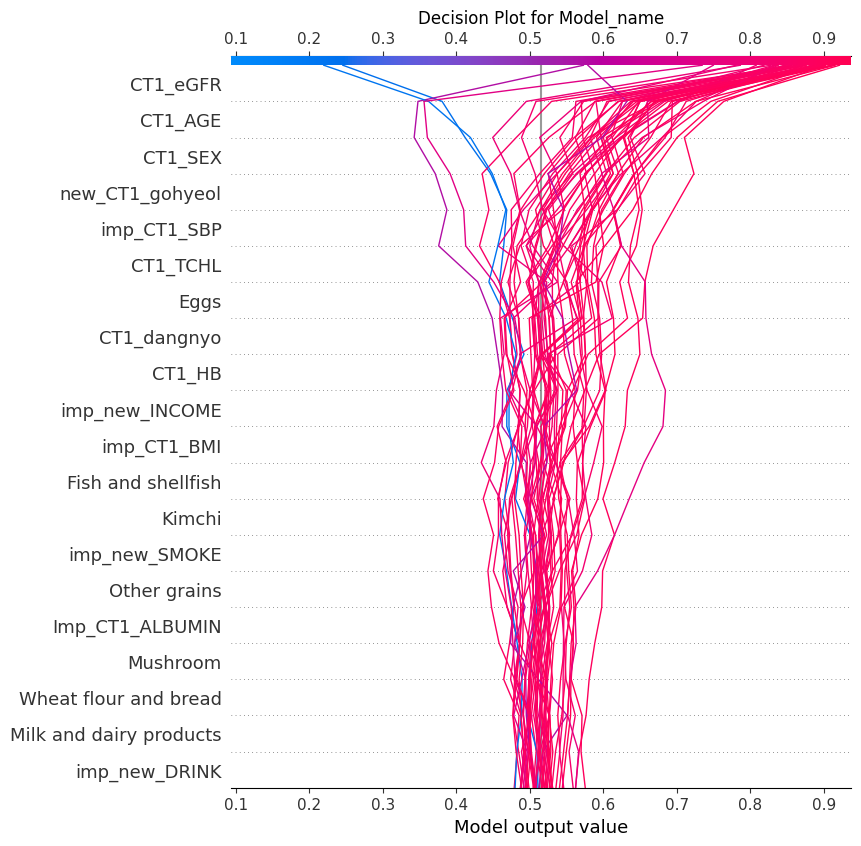

In [10]:
# 새로운 shap value 계산
shap_values_new_data = temp_explainer.shap_values(new_data)

# 모든 새로운 sample에 대한 시각화.
shap.decision_plot(
    temp_explainer.expected_value,      # loaded explainer의 expected value
    shap_values_new_data,
    # shap_values_new_data[sample_index],     # 특정 샘플
    
    X_tight3_foodsum_test.values,     # 실제 값 (normalize 전)
    # X_tight3_foodsum_test.values[sample_index],       #  특정 샘플
    feature_names=total_cols,
    title="Decision Plot for Model_name"
)

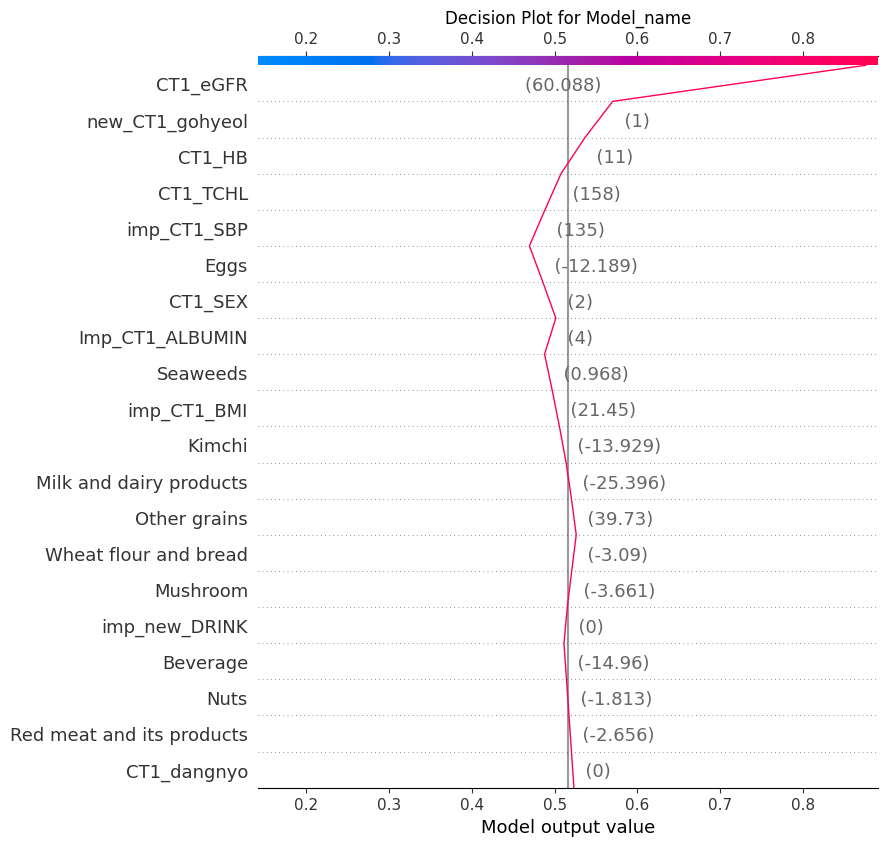

In [11]:
sample_index = 5

shap.decision_plot(
    temp_explainer.expected_value,      # loaded explainer의 expected value
    # shap_values_new_data,
    shap_values_new_data[sample_index],     # 특정 샘플
    
    # X_tight3_foodsum_test.values,     # 실제 값 (normalize 전)
    X_tight3_foodsum_test.values[sample_index],       #  특정 샘플
    feature_names=total_cols,
    title="Decision Plot for Model_name"
)

##### Basic only

In [ ]:
results_all_seed = {}

# total, basic, food
a, b = divide_testset(basic, ratio=0.1)

# test
y_tight3_foodsum_test = b['onset_tight']
X_tight3_foodsum_test = b.drop(['RID', 'onset_tight'], axis=1)

In [ ]:
""" Total Dataset ( Food + Basic ) """

results_all_seed = {}
shap_per_seed = []

for seed in [42, 59, 63, 79, 101]:    
# for seed in [42]:    
    datas = {"original":(), "undersampling":(), "oversampling":()}

    datas['undersampling'] = undersampling(a, seed=seed)        # eGFR 만을 빼면 성능이 줄어든다..
    datas['oversampling'] = oversampling(a, seed=seed)
    y_tight3_foodsum_train = a['onset_tight']
    X_tight3_foodsum_train = a.drop(['RID', 'onset_tight'], axis=1)
    datas['original'] = (X_tight3_foodsum_train, y_tight3_foodsum_train)
    
    results_all_seed[seed] = {}  # 각 시드마다 딕셔너리 생성
    
    for data in ['undersampling']:
        print(f"For {data} dataset!!!")
        # X_test, y_test = datas['test']
        X_train, y_train = datas[data]
        print(X_train.shape, y_train.shape)
        # print(y_train)
        
        # wei_train_scaler = StandardScaler()
        # X_train = wei_train_scaler.fit_transform(X_train)
        # X_test = wei_train_scaler.transform(X_test)
        print(f"{data} dataset loaded and scaled")
        print(f"X_train :: {X_train.shape}, y_train :: {y_train.shape}")
        
        models = (
            SVC(kernel='linear', random_state=seed, probability=True),
            RandomForestClassifier(random_state=seed, max_depth=3),
            LogisticRegression(max_iter=1000, random_state=seed),
            GradientBoostingClassifier(random_state=seed, max_depth=3, learning_rate=0.01),
            GaussianNB(var_smoothing=1e-7),     # 1e-11, 1e-10, 1e-9, 1e-8, 1e-7
        )
        
        # model = models[0]
        for model in models:
            model.fit(X_train, y_train)
            print(f"{model.__class__.__name__} Model fitted!!")
        
        for trained_model in models:
            model_name = trained_model.__class__.__name__  # 모델 이름 저장
            
            # # shap
            # explainer = shap.TreeExplainer(trained_model)
            # shap_val = explainer.shap_values(X_tight3_foodsum_test)
            # shap_per_seed.append(shap_val)
            # print(shap_val.shape)
            
            print("="*30)
            print(f"Predicting {model_name}!!")
            preds = trained_model.predict(X_tight3_foodsum_test)
            model_probabilities = trained_model.predict_proba(X_tight3_foodsum_test)[:, 1]
            print("=" * 30)
            print(seed)
            recall, precision, acc, auc, cm = get_results(y_tight3_foodsum_test, np.array(preds), model_probabilities)
            print("=" * 30)
            
            # 결과 저장
            if model_name not in results_all_seed[seed]:
                results_all_seed[seed][model_name] = {
                    'recall': [], 
                    'precision': [], 
                    'accuracy': [], 
                    'auc': [],
                    'cm' : []
                }
            results_all_seed[seed][model_name]['recall'].append(recall)
            results_all_seed[seed][model_name]['precision'].append(precision)
            results_all_seed[seed][model_name]['accuracy'].append(acc)
            results_all_seed[seed][model_name]['auc'].append(auc)
            results_all_seed[seed][model_name]['cm'].append(cm)
            
print_seed_results(results_all_seed)
shap_per_seed_mean = np.mean(np.array(shap_per_seed), axis=0)

In [ ]:
# shap 가져와서 visualization
shap_values_loaded = []

seeds = [42, 59, 63, 79, 101]

for seed in seeds:
    shap_path = f"/home/user19/pnu_ckd/hexa_preprocessing_after95/0911_dl_models/shap_figs_1208_morecontrol/basic_under_seed{seed}/MLP/shap_values_MLP.pk"
    with open(shap_path, 'rb') as f:
        temp_shap = pickle.load(f)
    shap_values_loaded.append(temp_shap)
    
shap_values_loaded_mean = np.mean(np.array(shap_values_loaded), axis=0)

In [ ]:
plt.figure()
shap.summary_plot(shap_values_loaded_mean, X_tight3_foodsum_test.values, feature_names=basic_cols,       # X_test 자리에 (ndarray)를 넣어야 색깔이 나옴.
                  cmap='bwr', show=False)
plt.title("Shap summary plot")
plt.show()

##### Basic only save and shap

In [ ]:
# total, basic, food
a, b = divide_testset(basic, ratio=0.1)

# test
y_tight3_foodsum_test = b['onset_tight']
X_tight3_foodsum_test = b.drop(['RID', 'onset_tight'], axis=1)

In [ ]:
""" Model Fit & Shap value check & Save (model weight, shap_png, explainer, shap_value)"""

# seed = 59

for seed in [42, 59, 63, 79, 101]:
# for seed in [42]:
    # 저장 경로 설정
    dataset_name = "basic_under"
    shap_fig_dir = f"shap_figs_1224_morecontrol/{dataset_name}_seed{seed}"
    os.makedirs(shap_fig_dir, exist_ok=True)  # 폴더가 없으면 생성

    # Data 준비
    datas = {"original":(), "undersampling":(), "oversampling":()}

    datas['undersampling'] = undersampling(a, seed=seed)
    datas['oversampling'] = oversampling(a, seed=seed)
    y_tight3_foodsum_train = a['onset_tight']
    X_tight3_foodsum_train = a.drop(['RID', 'onset_tight'], axis=1)
    datas['original'] = (X_tight3_foodsum_train, y_tight3_foodsum_train)

    for data in ['undersampling']:
        print(f"For {data} dataset!!!")
        X_train, y_train = datas[data]
        print(X_train.shape, y_train.shape)
        # print(y_train)
        
        # wei_train_scaler = StandardScaler()
        # X_train = wei_train_scaler.fit_transform(X_train)
        # X_test = wei_train_scaler.transform(X_test)
        print(f"{data} dataset loaded and scaled")
        print(f"X_train :: {X_train.shape}, y_train :: {y_train.shape}")
        
        shap_values_all_models = {"SVC" : [],
                            "RandomForest" : [],
                            "LogisticRegression" : [],
                            "GradientBoosting" : [],
                            "GNB" : []
                            }
        
        models = [
        ("SVC", SVC(kernel='linear', random_state=seed, probability=True)),     # 50분 소요
        ("RandomForest", RandomForestClassifier(random_state=seed, max_depth=3)),
        ("LogisticRegression", LogisticRegression(max_iter=1000, random_state=seed)),
        ("GradientBoosting", GradientBoostingClassifier(random_state=seed, max_depth=3, learning_rate=0.01)),
        ("GNB", GaussianNB(var_smoothing=1e-7)),     # 1e-11, 1e-10, 1e-9, 1e-8, 1e-7       # 17분 소요
        ]
        
        for name, model in models:
            model.fit(X_train, y_train)
            print(f"{model.__class__.__name__} Model fitted!!")

        for name, trained_model in models:
            # SHAP Explainer 설정
            if name in ["RandomForest", "GradientBoosting"]:
                explainer = shap.TreeExplainer(trained_model)
            elif name in ["SVC", "GNB"]:
                explainer = shap.KernelExplainer(trained_model.predict_proba, shap.sample(X_train, 100))  # 샘플링하여 속도 향상
            elif name == "LogisticRegression":
                explainer = shap.LinearExplainer(trained_model, X_train)
            
            # model save
            save_path_model = os.path.join(shap_fig_dir, f"{trained_model.__class__.__name__}")
            os.makedirs(save_path_model, exist_ok=True)
            save_path_model_weights = os.path.join(save_path_model, f"{trained_model.__class__.__name__}_weights.joblib")
            dump(trained_model, save_path_model_weights)
            print(f"Model weight is saved to {save_path_model_weights}!!")
            
            # explainer save
            save_path_explainer = os.path.join(save_path_model, f"{trained_model.__class__.__name__}_explainer.joblib")
            dump(explainer, save_path_explainer)
            print(f"Explainer for {name} is saved to {save_path_explainer}!!")
            
            # SHAP 값 계산
            if name in ["SVC", "GNB"]:
                shap_values = explainer.shap_values(X_tight3_foodsum_test, silent=True)
            else:
                shap_values = explainer.shap_values(X_tight3_foodsum_test)
            shap_values_all_models[name].append(shap_values)
            
            # Summary plot 그리기 및 저장
            plt.figure()
            save_path_png = os.path.join(save_path_model, f"summary_plot, model_{trained_model.__class__.__name__}.png")

            if name in ["SVC", "RandomForest", "GNB"]:
                shap.summary_plot(shap_values[1], X_tight3_foodsum_test, feature_names=total_cols, show=False)
            else:
                shap.summary_plot(shap_values, X_tight3_foodsum_test, feature_names=total_cols, show=False)
            plt.title(f"Summary plot for of {trained_model.__class__.__name__}")
            plt.savefig(save_path_png)
            plt.close()
            
            # shap value 저장.
            shap_values_save_path = os.path.join(save_path_model, f"shap_values_{name}.pk")
            # pickle을 사용하여 shap_values_all_models 저장
            if name in ["SVC", "RandomForest", "GNB"]:
                with open(shap_values_save_path, 'wb') as f:
                    pickle.dump(shap_values[1], f)
            else:
                with open(shap_values_save_path, 'wb') as f:
                    pickle.dump(shap_values, f)
            print(f"SHAP values of {name} model on seed {seed}, is saved to {shap_values_save_path}.")

##### Food only

In [ ]:
results_all_seed = {}

# total, basic, food
a, b = divide_testset(food, ratio=0.1)

# test
y_tight3_foodsum_test = b['onset_tight']
X_tight3_foodsum_test = b.drop(['RID', 'onset_tight'], axis=1)

In [ ]:
""" Total Dataset ( Food + Basic ) """

results_all_seed = {}

for seed in [42, 59, 63, 79, 101]:    
# for seed in [42]:    
    datas = {"original":(), "undersampling":(), "oversampling":()}

    datas['undersampling'] = undersampling(a, seed=seed)        # eGFR 만을 빼면 성능이 줄어든다..
    datas['oversampling'] = oversampling(a, seed=seed)
    y_tight3_foodsum_train = a['onset_tight']
    X_tight3_foodsum_train = a.drop(['RID', 'onset_tight'], axis=1)
    datas['original'] = (X_tight3_foodsum_train, y_tight3_foodsum_train)
    
    results_all_seed[seed] = {}  # 각 시드마다 딕셔너리 생성
    
    for data in ['undersampling']:
        print(f"For {data} dataset!!!")
        # X_test, y_test = datas['test']
        X_train, y_train = datas[data]
        print(X_train.shape, y_train.shape)
        # print(y_train)
        
        # wei_train_scaler = StandardScaler()
        # X_train = wei_train_scaler.fit_transform(X_train)
        # X_test = wei_train_scaler.transform(X_test)
        print(f"{data} dataset loaded and scaled")
        print(f"X_train :: {X_train.shape}, y_train :: {y_train.shape}")
        
        models = (
            SVC(kernel='linear', random_state=seed, probability=True),
            RandomForestClassifier(random_state=seed, max_depth=3),
            LogisticRegression(max_iter=1000, random_state=seed),
            GradientBoostingClassifier(random_state=seed, max_depth=3, learning_rate=0.01),
            GaussianNB(var_smoothing=1e-7),     # 1e-11, 1e-10, 1e-9, 1e-8, 1e-7
        )
        
        model = models[0]
        for model in models:
            model.fit(X_train, y_train)
            print(f"{model.__class__.__name__} Model fitted!!")
        
        for trained_model in models:
            model_name = trained_model.__class__.__name__  # 모델 이름 저장
            print("="*30)
            print(f"Predicting {model_name}!!")
            preds = trained_model.predict(X_tight3_foodsum_test)
            model_probabilities = trained_model.predict_proba(X_tight3_foodsum_test)[:, 1]
            print("=" * 30)
            print(seed)
            recall, precision, acc, auc, cm = get_results(y_tight3_foodsum_test, np.array(preds), model_probabilities)
            print("=" * 30)
            
            # 결과 저장
            if model_name not in results_all_seed[seed]:
                results_all_seed[seed][model_name] = {
                    'recall': [], 
                    'precision': [], 
                    'accuracy': [], 
                    'auc': [],
                    'cm' : []
                }
            results_all_seed[seed][model_name]['recall'].append(recall)
            results_all_seed[seed][model_name]['precision'].append(precision)
            results_all_seed[seed][model_name]['accuracy'].append(acc)
            results_all_seed[seed][model_name]['auc'].append(auc)
            results_all_seed[seed][model_name]['cm'].append(cm)
            
print_seed_results(results_all_seed)

##### Food only save and shap

In [ ]:
# total, basic, food
a, b = divide_testset(food, ratio=0.1)

# test
y_tight3_foodsum_test = b['onset_tight']
X_tight3_foodsum_test = b.drop(['RID', 'onset_tight'], axis=1)

In [ ]:
""" Model Fit & Shap value check & Save (model weight, shap_png, explainer, shap_value)"""

# seed = 59

for seed in [42, 59, 63, 79, 101]:
# for seed in [42]:
    # 저장 경로 설정
    dataset_name = "food_under"
    shap_fig_dir = f"shap_figs_1224_morecontrol/{dataset_name}_seed{seed}"
    os.makedirs(shap_fig_dir, exist_ok=True)  # 폴더가 없으면 생성

    # Data 준비
    datas = {"original":(), "undersampling":(), "oversampling":()}

    datas['undersampling'] = undersampling(a, seed=seed)
    datas['oversampling'] = oversampling(a, seed=seed)
    y_tight3_foodsum_train = a['onset_tight']
    X_tight3_foodsum_train = a.drop(['RID', 'onset_tight'], axis=1)
    datas['original'] = (X_tight3_foodsum_train, y_tight3_foodsum_train)

    for data in ['undersampling']:
        print(f"For {data} dataset!!!")
        X_train, y_train = datas[data]
        print(X_train.shape, y_train.shape)
        # print(y_train)
        
        # wei_train_scaler = StandardScaler()
        # X_train = wei_train_scaler.fit_transform(X_train)
        # X_test = wei_train_scaler.transform(X_test)
        print(f"{data} dataset loaded and scaled")
        print(f"X_train :: {X_train.shape}, y_train :: {y_train.shape}")
        
        shap_values_all_models = {"SVC" : [],
                            "RandomForest" : [],
                            "LogisticRegression" : [],
                            "GradientBoosting" : [],
                            "GNB" : []
                            }
        
        models = [
        ("SVC", SVC(kernel='linear', random_state=seed, probability=True)),     # 50분 소요
        ("RandomForest", RandomForestClassifier(random_state=seed, max_depth=3)),
        ("LogisticRegression", LogisticRegression(max_iter=1000, random_state=seed)),
        ("GradientBoosting", GradientBoostingClassifier(random_state=seed, max_depth=3, learning_rate=0.01)),
        ("GNB", GaussianNB(var_smoothing=1e-7)),     # 1e-11, 1e-10, 1e-9, 1e-8, 1e-7       # 17분 소요
        ]
        
        for name, model in models:
            model.fit(X_train, y_train)
            print(f"{model.__class__.__name__} Model fitted!!")

        for name, trained_model in models:
            # SHAP Explainer 설정
            if name in ["RandomForest", "GradientBoosting"]:
                explainer = shap.TreeExplainer(trained_model)
            elif name in ["SVC", "GNB"]:
                explainer = shap.KernelExplainer(trained_model.predict_proba, shap.sample(X_train, 100))  # 샘플링하여 속도 향상
            elif name == "LogisticRegression":
                explainer = shap.LinearExplainer(trained_model, X_train)
            
            # model save
            save_path_model = os.path.join(shap_fig_dir, f"{trained_model.__class__.__name__}")
            os.makedirs(save_path_model, exist_ok=True)
            save_path_model_weights = os.path.join(save_path_model, f"{trained_model.__class__.__name__}_weights.joblib")
            dump(trained_model, save_path_model_weights)
            print(f"Model weight is saved to {save_path_model_weights}!!")
            
            # explainer save
            save_path_explainer = os.path.join(save_path_model, f"{trained_model.__class__.__name__}_explainer.joblib")
            dump(explainer, save_path_explainer)
            print(f"Explainer for {name} is saved to {save_path_explainer}!!")
            
            # SHAP 값 계산
            if name in ["SVC", "GNB"]:
                shap_values = explainer.shap_values(X_tight3_foodsum_test, silent=True)
            else:
                shap_values = explainer.shap_values(X_tight3_foodsum_test)
            shap_values_all_models[name].append(shap_values)
            
            # Summary plot 그리기 및 저장
            plt.figure()
            save_path_png = os.path.join(save_path_model, f"summary_plot, model_{trained_model.__class__.__name__}.png")

            if name in ["SVC", "RandomForest", "GNB"]:
                shap.summary_plot(shap_values[1], X_tight3_foodsum_test, feature_names=total_cols, show=False)
            else:
                shap.summary_plot(shap_values, X_tight3_foodsum_test, feature_names=total_cols, show=False)
            plt.title(f"Summary plot for of {trained_model.__class__.__name__}")
            plt.savefig(save_path_png)
            plt.close()
            
            # shap value 저장.
            shap_values_save_path = os.path.join(save_path_model, f"shap_values_{name}.pk")
            # pickle을 사용하여 shap_values_all_models 저장
            if name in ["SVC", "RandomForest", "GNB"]:
                with open(shap_values_save_path, 'wb') as f:
                    pickle.dump(shap_values[1], f)
            else:
                with open(shap_values_save_path, 'wb') as f:
                    pickle.dump(shap_values, f)
            print(f"SHAP values of {name} model on seed {seed}, is saved to {shap_values_save_path}.")